#### 一个简单的DQN与伪日内策略框架
[github](https://github.com/AlphaSmartDog/DeepLearningNotes/tree/master/Note-5%20Agent%20Thinker)
- 本文使用HS300指数数据
- 简单构建一个环境，一个虚拟的交易账户，可以是股指期货或者商品期货，进行日线级别交易，每交易日开盘价交割，收盘价评估。
- 设计决策者，即虚拟交易员，每日开盘前预判今日走势，如果今日收盘价高于开盘价做多，收盘价低于开盘价做空，并且设置摩擦成本，开盘收盘价差小于一定值空仓。

不同于此前博客介绍的RNN用于股票的预测，RL在每个state（或帧）预测的是折扣未来预期收益（此处可以理解为远期标折现）。对比RNN模型，RL模型在对股票市场未来走势的预测方面更加宽松或更鲁棒。RL在$s_t$产生的预测由未来预期收益由真实奖励$R_t$ 和逼近函数模型估计未来一段时间折扣收益组成。这相比于RNN更加宽松，因为我们不能期望股票市场的模式或者状态与未来股价走势存在严格的函数关系，也就是不应该期望在$t$ 时刻的事件精准的反馈在$t+k$ 时刻的股价上面。此外通常在实际使用RL模型的时候不需要特别精确的收敛，通常只要达到一定的准确程度或一定的收敛范围即可。

RL在状态state($s_t$) 预测是庞大但有限预期收益折现值。

$predict_t= G_t \doteq \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}\\=R_t+ \sum_{k=1}^{\infty} \gamma^k R_{t+k+1} $

RNN在状态$s_t$ 预测的是未来某个节点或者节点很小波动范围内的预期收益。

$predict_t= R_{t+k} + Var(R_{t+k}) $

然而针对决策过程设计的RL系统，大多数强制假设马尔可夫决策过程(Markov Decision Processes)，当然这在工程应用中具有极好的效果，通常非马尔科夫属性的决策过程也可以通过MDP有效的近似。然而不同于工业应用场景，虚拟交易员(Agent)在A股市场面对的是一个动态变化的环境，不同于前面的工业应用，A股市场Environment 的规则是动态变动的，并且这种变动通常无法从盘面数据预测。此外，RL系统一般可以通过选择action来控制或影响情景发展，如AlphaGo、DQN等在围棋、游戏上面的动作可以切实影响RL决策系统未来接受的state， 但是Agent的行为难以影响A股市场，或无法捕捉这种行为影响。也就是，Agent对action的决策只能影响到未来获得奖励，而无法对交互环境产生影响。

Agent for game

$action \to reward\ and \ next\ state$

Agent for A股

$action \to reward$


## 1 交易账户-虚拟环境构建

In [1]:
import numpy as np
import pandas as pd
import talib 

def fix_data(path):
    tmp = pd.read_csv(path, encoding="gbk", engine='python')
    tmp.rename(columns={'Unnamed: 0':'trading_time'}, inplace=True)
    tmp['trading_point'] = pd.to_datetime(tmp.trading_time)
    del tmp['trading_time']
    tmp.set_index(tmp.trading_point, inplace=True)
    return tmp

def High_2_Low(tmp, freq):
    """处理从RiceQuant下载的分钟线数据，
    从分钟线数据合成低频数据
    2017-08-11    
    """
    # 分别处理bar数据
    tmp_open = tmp['open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['high'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)
    
    # 处理成交量
    tmp_volume = tmp['volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)
    
    return pd.concat([tmp_price, tmp_volume], axis=1)

def get_factors(index, 
                Open, 
                Close, 
                High, 
                Low, 
                Volume,
                rolling = 26,
                drop=False, 
                normalization=True):
    
    tmp = pd.DataFrame()
    tmp['tradeTime'] = index
    
    #累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    #用以计算成交量的动量。属于趋势型因子
    tmp['AD'] = talib.AD(High, Low, Close, Volume)

    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    tmp['ADOSC'] = talib.ADOSC(High, Low, Close, Volume, fastperiod=3, slowperiod=10)

    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADX'] = talib.ADX(High, Low, Close,timeperiod=14)

    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADXR'] = talib.ADXR(High, Low, Close,timeperiod=14)

    # 绝对价格振荡指数
    tmp['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26)

    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    #Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    tmp['AROONDown'], tmp['AROONUp'] = talib.AROON(High, Low,timeperiod=14)
    tmp['AROONOSC'] = talib.AROONOSC(High, Low,timeperiod=14)

    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    #是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    tmp['ATR14']= talib.ATR(High, Low, Close, timeperiod=14)
    tmp['ATR6']= talib.ATR(High, Low, Close, timeperiod=6)

    # 布林带
    tmp['Boll_Up'],tmp['Boll_Mid'],tmp['Boll_Down']= talib.BBANDS(Close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # 均势指标
    tmp['BOP'] = talib.BOP(Open, High, Low, Close)

    #5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    tmp['CCI5'] = talib.CCI(High, Low, Close, timeperiod=5)
    tmp['CCI10'] = talib.CCI(High, Low, Close, timeperiod=10)
    tmp['CCI20'] = talib.CCI(High, Low, Close, timeperiod=20)
    tmp['CCI88'] = talib.CCI(High, Low, Close, timeperiod=88)

    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    tmp['CMO_Close'] = talib.CMO(Close,timeperiod=14)
    tmp['CMO_Open'] = talib.CMO(Close,timeperiod=14)

    # DEMA双指数移动平均线
    tmp['DEMA6'] = talib.DEMA(Close, timeperiod=6)
    tmp['DEMA12'] = talib.DEMA(Close, timeperiod=12)
    tmp['DEMA26'] = talib.DEMA(Close, timeperiod=26)

    # DX 动向指数
    tmp['DX'] = talib.DX(High, Low, Close,timeperiod=14)

    # EMA 指数移动平均线
    tmp['EMA6'] = talib.EMA(Close, timeperiod=6)
    tmp['EMA12'] = talib.EMA(Close, timeperiod=12)
    tmp['EMA26'] = talib.EMA(Close, timeperiod=26)

    # KAMA 适应性移动平均线
    tmp['KAMA'] = talib.KAMA(Close, timeperiod=30)

    # MACD
    tmp['MACD_DIF'],tmp['MACD_DEA'],tmp['MACD_bar'] = talib.MACD(Close, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    tmp['MEDPRICE'] = talib.MEDPRICE(High, Low)

    # 负向指标 负向运动
    tmp['MiNUS_DI'] = talib.MINUS_DI(High, Low, Close,timeperiod=14)
    tmp['MiNUS_DM'] = talib.MINUS_DM(High, Low,timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    #减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    tmp['MOM'] = talib.MOM(Close, timeperiod=10)

    # 归一化平均值范围
    tmp['NATR'] = talib.NATR(High, Low, Close,timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    #从而研判股价的走势。属于成交量型因子
    tmp['OBV'] = talib.OBV(Close, Volume)

    # PLUS_DI 更向指示器
    tmp['PLUS_DI'] = talib.PLUS_DI(High, Low, Close,timeperiod=14)
    tmp['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)

    # PPO 价格振荡百分比
    tmp['PPO'] = talib.PPO(Close, fastperiod=6, slowperiod= 26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    #通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROC6'] = talib.ROC(Close, timeperiod=6)
    tmp['ROC20'] = talib.ROC(Close, timeperiod=20)
    #12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    #通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    #达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    #属于成交量的反趋向指标。属于成交量型因子
    tmp['VROC6'] = talib.ROC(Volume, timeperiod=6)
    tmp['VROC20'] = talib.ROC(Volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    #通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROCP6'] = talib.ROCP(Close, timeperiod=6)
    tmp['ROCP20'] = talib.ROCP(Close, timeperiod=20)
    #12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    #通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    #达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    #属于成交量的反趋向指标。属于成交量型因子
    tmp['VROCP6'] = talib.ROCP(Volume, timeperiod=6)
    tmp['VROCP20'] = talib.ROCP(Volume, timeperiod=20)

    # RSI
    tmp['RSI'] = talib.RSI(Close, timeperiod=14)

    # SAR 抛物线转向
    tmp['SAR'] = talib.SAR(High, Low, acceleration=0.02, maximum=0.2)

    # TEMA
    tmp['TEMA6'] = talib.TEMA(Close, timeperiod=6)
    tmp['TEMA12'] = talib.TEMA(Close, timeperiod=12)
    tmp['TEMA26'] = talib.TEMA(Close, timeperiod=26)

    # TRANGE 真实范围
    tmp['TRANGE'] = talib.TRANGE(High, Low, Close)

    # TYPPRICE 典型价格
    tmp['TYPPRICE'] = talib.TYPPRICE(High, Low, Close)

    # TSF 时间序列预测
    tmp['TSF'] = talib.TSF(Close, timeperiod=14)

    # ULTOSC 极限振子
    tmp['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

    # 威廉指标
    tmp['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)
    
    # 标准化
    if normalization:
        factors_list = tmp.columns.tolist()[1:]

        if rolling >= 26:
            for i in factors_list:
                tmp[i] = (tmp[i] - tmp[i].rolling(window=rolling, center=False).mean())\
                /tmp[i].rolling(window=rolling, center=False).std()
        elif rolling < 26 & rolling > 0:
            print ('Recommended rolling range greater than 26')
        elif rolling <=0:
            for i in factors_list:
                tmp[i] = (tmp[i] - tmp[i].mean())/tmp[i].std()
            
    if drop:
        tmp.dropna(inplace=True)
        
    tmp.set_index('tradeTime', inplace=True)
    
    return tmp

In [2]:
tmp = fix_data('HS300.csv')
tmp = High_2_Low(tmp, '5min')
Dtmp = High_2_Low(tmp, '1d')

Index = tmp.index
High = tmp.high.values
Low = tmp.low.values
Close = tmp.close.values
Open = tmp.open.values
Volume = tmp.volume.values
factors = get_factors(Index, Open, Close, High, Low, Volume, rolling = 188, drop=True)

Dtmp['returns'] = np.log(Dtmp['close'].shift(-1)/Dtmp['close'])
Dtmp.dropna(inplace=True)

start_date = pd.to_datetime('2011-01-12')
end_date = pd.to_datetime('2016-12-29')
Dtmp = Dtmp.loc[start_date:end_date]
Dtmp = Dtmp.iloc[5:]
factors = factors.loc[start_date:end_date]

flist = []
for i in range(len(Dtmp)):
    s = i * 50
    e = (i + 5) * 50
    f = np.array(factors.iloc[s:e])
    flist.append(np.expand_dims(f, axis=0))

fac_array = np.concatenate(flist, axis=0)
shape = [fac_array.shape[0], 5, 50, fac_array.shape[2]]
fac_array = fac_array.reshape(shape)
fac_array = np.transpose(fac_array, [0,2,3,1])

data_quotes = Dtmp
data_fac = fac_array

In [3]:
class Account(object):
    
    def __init__(self, data_quotes, data_fac):
        self.data_close = data_quotes['close']
        self.data_open = data_quotes['open']
        self.data_observation = data_fac
        self.action_space = ['long', 'short', 'close']
        self.free = 1e-4
        self.reset()

    def reset(self):
        self.step_counter = 0
        self.cash = 1e5
        self.position = 0
        self.total_value = self.cash + self.position
        self.flags = 0
        
    def get_initial_state(self):
        return np.expand_dims(self.data_observation[0],axis=0)
    
    def get_action_space(self):
        return self.action_space

    def long(self):
        self.flags = 1
        quotes = self.data_open[self.step_counter] * 10
        self.cash -= quotes * (1 + self.free)
        self.position = quotes 
        
    def short(self):
        self.flags = -1
        quotes = self.data_open[self.step_counter] * 10
        self.cash += quotes * (1 - self.free)
        self.position = - quotes        
        
    def keep(self):
        quotes = self.data_open[self.step_counter] * 10
        self.position = quotes * self.flags
        
    def close_long(self): 
        self.flags = 0
        quotes = self.data_open[self.step_counter] * 10
        self.cash += quotes * (1 - self.free) 
        self.position = 0  
        
    def close_short(self):
        self.flags = 0
        quotes = self.data_open[self.step_counter] * 10
        self.cash -= quotes * (1 + self.free) 
        self.position = 0  

    def step_op(self, action):
        
        if action == 'long':
            if self.flags == 0:
                self.long()
            elif self.flags == -1:
                self.close_short()
                self.long()
            else:
                self.keep() 
        
        elif action == 'close':
            if self.flags == 1:
                self.close_long()
            elif self.flags == -1:
                self.close_short()
            else:
                pass
                
        elif action == 'short':
            if self.flags == 0:
                self.short()
            elif self.flags == 1:
                self.close_long()
                self.short()
            else:
                self.keep()
        else:
            raise ValueError("action should be elements of ['long', 'short', 'close']")
            
        position = self.data_close[self.step_counter] * 10 * self.flags
        reward = self.cash + position - self.total_value
        self.step_counter += 1
        self.total_value = position + self.cash
        next_observation = self.data_observation[self.step_counter]
        
        done = False
        if self.total_value < 4000:
            done = True
        if self.step_counter > 600:
            done = True
            
        return reward, np.expand_dims(next_observation, axis=0), done
    
    def step(self, action):
        if action == 0:
            return self.step_op('long')
        elif action == 1:
            return self.step_op('short')
        elif action == 2:
            return self.step_op('close')
        else:
            raise ValueError("action should be one of [0,1,2]")
    
    def get_next_state(self):
        self.step_counter += 1
        next_observation = self.data_observation[self.step_counter]
        return np.expand_dims(next_observation, axis=0)

In [4]:
env = Account(data_quotes, data_fac)

### 2 虚拟决策者构建

In [5]:
import random
import numpy as np
import tensorflow as tf
from collections import deque

In [6]:
class DQNCore(object):
    def __init__(self, observation, num_actions, learning_rate=1e-3, memory_size=1024, batch_size=32, gamma=.9, name='DNCore'):
        self.num_actions = num_actions
        self.memory_size = memory_size
        self.gamma = gamma # discount factor for excepted returns 
        self.batch_size = 32
        
        # placeholder for samples replay experience
        shape = [None] + list(observation.shape [1:])
        self.inputs = tf.placeholder(tf.float32, shape, 'inputs')
        self.targets = tf.placeholder(tf.float32, [None], 'targets') # y_j
        self.actions = tf.placeholder(tf.int32, [None], 'actions')
        self.rewards = tf.placeholder(tf.float32, [None], 'rewards')
        self.Q = self._build_QNetwork('Qeval', True) # state Q
        self.next_Q = self._build_QNetwork('next_eval',False) # next state Q
        
        # actions selection corresponding one hot matrix column
        one_hot = tf.one_hot(self.actions, self.num_actions, 1., 0.)
        Qmax = tf.reduce_sum(self.Q * one_hot, axis=1)
        self._loss = tf.reduce_mean(tf.squared_difference(Qmax, self.targets))
        self._train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(self._loss)
        
        # session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())   
        
    def init(self):
        self.step_counter = 0       
        self.cache = deque(maxlen=self.memory_size) # replay experience

    def _build_QNetwork(self, name, trainable):
        with tf.variable_scope(name):
            # input layer
            network = tf.layers.conv2d(self.inputs, 16, [8,8], [4,4], 'same', 
                                       activation=tf.nn.relu, trainable=trainable, name='input_layer')
            # hidden layer
            network = tf.layers.conv2d(network, 32, [4,4], [2,2], 'same', 
                                       activation=tf.nn.relu, trainable=trainable, name='hidden_layer')
            # final layer
            network = tf.contrib.layers.flatten(network)
            network = tf.layers.dense(network, 64, tf.nn.relu, 
                                      trainable=trainable, name='final_layer')
            # output layer
            network = tf.layers.dense(network, self.num_actions, None, 
                                      trainable=trainable, name='output_layer')
            return network

    def update_nextQ_network(self): 
        next_params = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, 
            scope='next_eval')
        Q_params = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, 
            scope='Qeval')
        # zip 长度不等时，取长度的最小的
        self.sess.run([tf.assign(n,q) for n,q in zip(next_params, Q_params)])

    def update_cache(self, state, action, reward, next_state, done):
        # update replay experience pool
        self.cache.append((state, action, reward, next_state, done))

    def _get_minibatch(self):
        # get samples from replay experience pool
        minibatch = random.sample(self.cache, self.batch_size) 
        state = np.vstack([i[0] for i in minibatch])
        action = np.squeeze(np.vstack([i[1] for i in minibatch]))
        reward = np.squeeze(np.vstack([i[2] for i in minibatch]))
        next_state = np.vstack([i[3] for i in minibatch])
        done = [i[4] for i in minibatch]
        return state, action, reward, next_state, done

    def step_learning(self):
        # samples from repaly experience pool
        state, action, reward, next_state, done = self._get_minibatch()
        next_Q = self.sess.run(self.next_Q, feed_dict={self.inputs:next_state})
        # done mask True 1 False 0
        mask = np.array(done).astype('float')
        target = mask * reward + (1 - mask) * \
        (reward + self.gamma * np.max(next_Q, axis=1))
        
        # op gradient descent step 
        self.sess.run(self._train_op, 
                      feed_dict={self.inputs:state, 
                                 self.actions:action, 
                                 self.targets:target})    
        
    def greedy_policy(self, observation):
        # 注：只在优化逼近函数参数过程使用 varepsilon greedy policy
        action_value = self.sess.run(
            self.Q, feed_dict={self.inputs:observation})
        return np.argmax(action_value, axis=1)[0]
    
    def varepsilon_greedy_policy(self, observation, varepsilon=0.9):
        if np.random.uniform() < varepsilon:
            action = self.greedy_policy(observation)
        else:
            action = np.random.randint(self.num_actions)
        return action

### 3 训练交易员 DQN

In [7]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [8]:
init_state = env.get_initial_state()
action_space = env.get_action_space()
agent = DQNCore(init_state, len(action_space))

#####  这里只是简单的代码运行示例，只进行的10次训练，这仅仅是出于示例考量，不代表DQN仅仅训练10次就近似数值稳定收敛。。。。

In [9]:
MAX_EPISODE = 10

global_counter = 0
varepsilon = 0

for episode in range(MAX_EPISODE):
    print (episode)
    step_counter = 0
    env.reset()
    state = env.get_initial_state()
    agent.init()
    while True:
        global_counter += 1
        step_counter += 1
        if global_counter % 500 == 0:
            varepsilon += 5e-5
        
        action = agent.varepsilon_greedy_policy(state, varepsilon)
        reward, next_state, done = env.step(action)
        agent.update_cache(state, action, reward, next_state, done)
        state = next_state
        
        if global_counter > 500 and step_counter > 32:
            agent.step_learning()
        if global_counter % 500 ==0:
            agent.update_nextQ_network()     
        
        if done:
            break

0
1
2
3
4
5
6
7
8
9


### 4 测试虚拟交易员水平

In [10]:
reward_list= []
value_list = []
env.reset()
state = env.get_initial_state()
for i in range(900):
    action = agent.greedy_policy(state)
    reward, next_state, done = env.step(action)
    state = next_state
    reward_list.append(reward)
    value_list.append(env.total_value)

# 净值走势图， 600之后为样本外测试

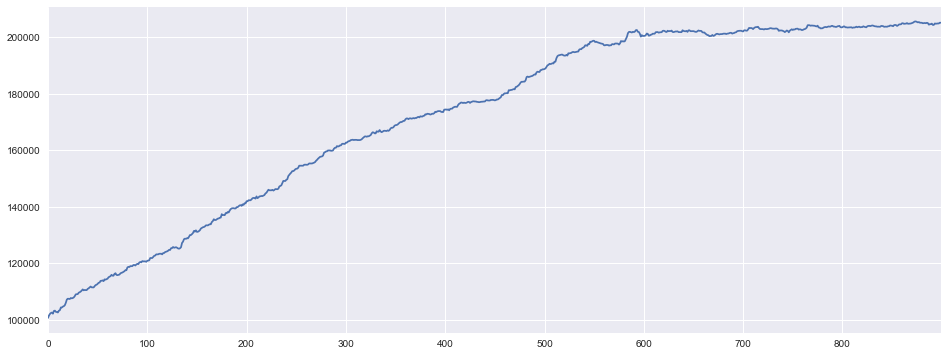

In [11]:
pd.Series(value_list).plot(figsize=(16,6))